### RNN
- sequence data의 모델링에 사용
- sequence 에서 현재 이후의 각 데이터는 새로운 정보를 제공하므로, 이 정보로 모델의 현재 상태를 갱신!
- 새로운 정보를 접했을 때는 '기억'이 사라지는 대신 '갱신'된다!
- 문장을 읽을 때 각각의 새로운 단어로 현재 상태의 정보가 갱신! (이전의 단어에 종속적)

- 일종의 루프
- 상태벡터 h_t 를 갱신하는 것
- 순환 구조는 하나의 긴 펼쳐놓은 체인으로 단순화한 개념 (~= HMM)

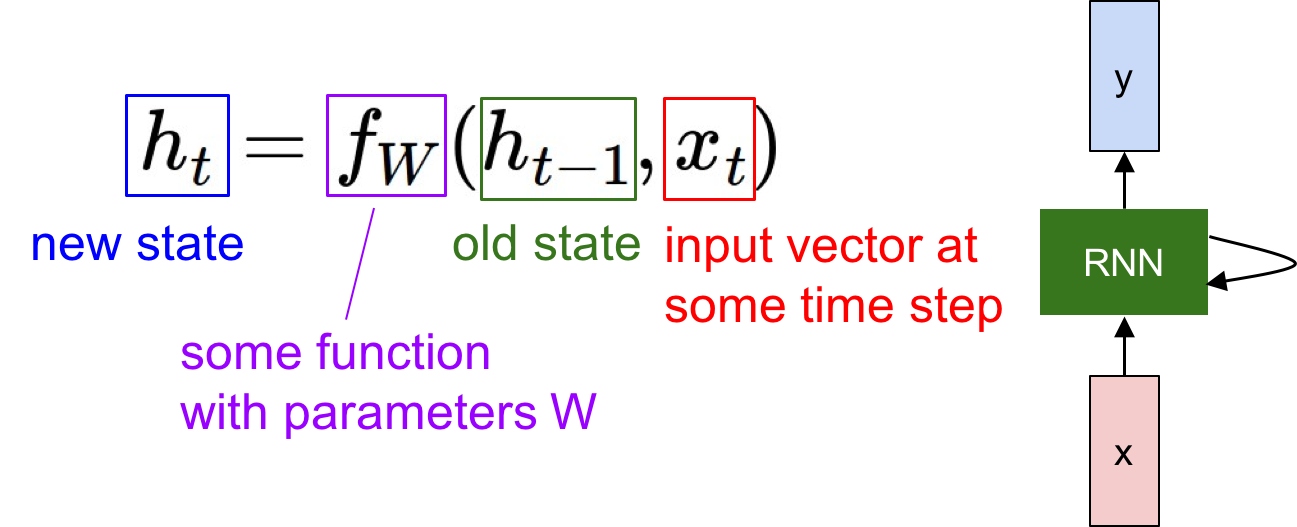

In [ ]:
from IPython.display import Image
Image("./RNN_concept.png")

### 생각해보기
- CNN Architecture 는 이미지의 공간 구조를 활용한다! 나선형!
- 다양한 각도에서 이미지 공간 구조를 본다는 측면에서 CNN 은 참 좋지만,
- 만약 이미지의 인접 영역이 어떤 식으로든 연관되어 있고, 그 연관성을 찾을 수 있다면?
- 이미지를 다양한 종류의 시퀀스 구조를 활용하여 들어다본다면? 어떻게 될까?
- e.g. 픽셀열

In [1]:
import tensorflow as tf

In [2]:
# data loading
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./tmp/data/t10k-images-idx3-ubyte.gz
Extracting ./tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


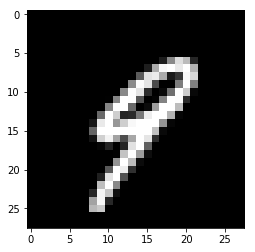

In [6]:
import matplotlib.pyplot as plt
batch = mnist.train.next_batch(1)
plotData = batch[0]
plotData = plotData.reshape(28, 28)
plt.gray() 
plt.imshow(plotData)
plt.show()

In [7]:
# parameter
element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128

In [8]:
# tensorboard summary model
LOG_DIR = "./log/RNN_with_summaries"

In [9]:
_input = tf.placeholder(tf.float32, 
                        shape=[None, time_steps, element_size],
                        name='inputs')
y = tf.placeholder(tf.float32,
                   shape=[None, num_classes],
                   name='labels')

In [10]:
# 28개 시퀀스를 얻기 위해 각 데이터를 28 픽셀의 형태로 변환
batch_x, batch_y = mnist.train.next_batch(batch_size) 
batch_x = batch_x.reshape((batch_size, time_steps, element_size))

In [11]:
# func. to record tf.summary log 
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [12]:
# 입력 및 은닉 계층에 적용할 가중치와 편향값
with tf.name_scope('rnn_weights'):
    with tf.name_scope('W_x'):
        Wx = tf.Variable(tf.zeros([element_size, hidden_layer_size]))
        variable_summaries(Wx)
    with tf.name_scope('W_h'):
        Wh = tf.Variable(tf.zeros([hidden_layer_size, hidden_layer_size]))
        variable_summaries(Wh)
    with tf.name_scope('Bias'):
        b_rnn = tf.Variable(tf.zeros([hidden_layer_size])) 
        variable_summaries(b_rnn) 

In [13]:
# RNN BAAM!
def rnn_step(previous_hidden_state, x):
    
    current_hidden_state = tf.tanh(
        tf.matmul(previous_hidden_state, Wh) + 
        tf.matmul(x, Wx) + b_rnn)

    return current_hidden_state


In [14]:
# (batch,size, time_steps, element_size) 
# transposed = [time_steps, batch_size, element_size]
processed_input = tf.transpose(_input, perm=[1,0,2]) 

In [15]:
initial_hidden = tf.zeros([batch_size, hidden_layer_size])

### tf.scan
## lets us write loops inside a computation graph, 
## allowing backpropagation and all
## Getting all state vectors across time
# 루프를 풀어놓지 않고 연산 그래프에 루프를 사용할 수 있게 해주는 함수
# 시간의 흐름에 따른 상태 벡터
all_hidden_states = tf.scan(rnn_step,
                           processed_input,
                           initializer = initial_hidden,
                           name='states')

In [16]:
# 출력(output layers)에 적용할 가중치
with tf.name_scope('linear_layer_weights') as scope:
    with tf.name_scope('W_linear'):
        Wl = tf.Variable(tf.truncated_normal([hidden_layer_size,
                                             num_classes],
                                            mean=0, stddev=.01))
        variable_summaries(Wl)
    
    with tf.name_scope('Bias_linear'):
        bl = tf.Variable(tf.truncated_normal([num_classes],
                                            mean=0, stddev=.01))
        variable_summaries(bl)

In [19]:
# state vector에 선형 계층 적용
def get_linear_layer(hidden_state):
    
    return tf.matmul(hidden_state, Wl) + bl

In [20]:
with tf.name_scope('linear_layer_weights') as scope:
    # 시간에 따라 반복하면서 모든 RNN 결과에 선형 계층 적용
    all_outputs = tf.map_fn(get_linear_layer, all_hidden_states)
    # 결과
    output = all_outputs[-1] # h_28 : 연결된 선형 계층의 마지막 state vector
    tf.summary.histogram('outputs', output)

- RNN 은 입력, 출력 모두 연속적
- 선형 계층의 마지막 h_t 를 적용해서 output vector 얻는다! "누적된 정보" !!!

In [22]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y))
    tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(0.001, 0.9).minimize(cross_entropy) # 책에서는 RMSPropOptimizer 추천

In [23]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(output, 1))

    accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100
    tf.summary.scalar('accuracy', accuracy)

# Merge all the summaries for Tensorboard
merged = tf.summary.merge_all() 

In [24]:
# Get a small test set
test_data = mnist.test.images[:batch_size].reshape((-1, time_steps, element_size))
test_label = mnist.test.labels[:batch_size]

In [29]:
with tf.Session() as sess:
    # Write summaries to LOG_DIR -- used by TensorBoard
    # LOG_DIR에 텐서보드에 사용할 요약 기록
    train_writer = tf.summary.FileWriter(LOG_DIR + '/train',
                                         graph=tf.get_default_graph())
    test_writer = tf.summary.FileWriter(LOG_DIR + '/test',
                                        graph=tf.get_default_graph())

    sess.run(tf.global_variables_initializer())

    for i in range(3000):

            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Reshape data to get 28 sequences of 28 pixels
            batch_x = batch_x.reshape((batch_size, time_steps, element_size))
            summary, _ = sess.run([merged, train_step],
                                  feed_dict={_input: batch_x, y: batch_y})
            # 요약 추가
            train_writer.add_summary(summary, i)

            if i % 1000 == 0:
                acc, loss, = sess.run([accuracy, cross_entropy],
                                      feed_dict={_input: batch_x,
                                                 y: batch_y})
                print("Iter " + str(i) + ", Minibatch Loss= " +
                      "{:.4f}".format(loss) + ", Training Accuracy= " +
                      "{:.4f}".format(acc))
            if i % 100 == 0:
                # 테스트 이미지에서 정확도 계산해서 요약에 추가
                # Calculate accuracy for 128 mnist test images and add to summaries
                summary, acc = sess.run([merged, accuracy],
                                        feed_dict={_input: test_data,
                                                   y: test_label})
                test_writer.add_summary(summary, i)

    test_acc = sess.run(accuracy, feed_dict={_input: test_data,
                                             y: test_label})
    print("Test Accuracy:", test_acc)


Iter 0, Minibatch Loss= 2.3021, Training Accuracy= 11.7188
Iter 1000, Minibatch Loss= 1.3347, Training Accuracy= 49.2188
Iter 2000, Minibatch Loss= 0.8779, Training Accuracy= 68.7500
Test Accuracy: 92.9688
